# Monte Carlo Prediction

We run several episodes with a policy, collecting hundreds of trajectories and then estimate the expectation using the empirical mean.

$\displaystyle V(S_t) = V(S_t) + \alpha_t [G_{t:T} - V(S_t)] $

The hyperparameter alpha is essential. Often, alpha is a positive constant less than 1. Having a constant alpha helps with learning in non-stationary environments. However, we can decay alpha in order to show convergence.

In [1]:
import numpy as np

def decay_alpha(init_value, min_value, decay_steps, max_steps):

    # calculate the number of the remaining steps after the decay
    rem_steps = max_steps - decay_steps
    
    # logspace returns numbers spaced evenly on a log scale
    # base^start is the starting value of the sequence,
    # base^stop is the final value of the sequence
    # num is the number of values to generate
    # base is the base of the log space
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    
    # because the values may not end exactly at 0, given it’s the log, 
    # we change them to be between 0 and 1 so that the curve looks smooth and nice.
    values = (values - values.min()) / (values.max() - values.min())
    
    # linear transformation and get points between init_value and min_value
    values = (init_value - min_value) * values + min_value
    
    # repeats the rightmost value rem_step number of times
    values = np.pad(values, (0, rem_steps), 'edge')
    
    return values

We use this schedule: alpha starts at 0.5, and it decreases exponentially to 0.01 in 250 episodes out of the 500 total episodes. In that way alpha helps the algorithms get close to converging, but because alpha don't goes to zero, they don’t fully converge.

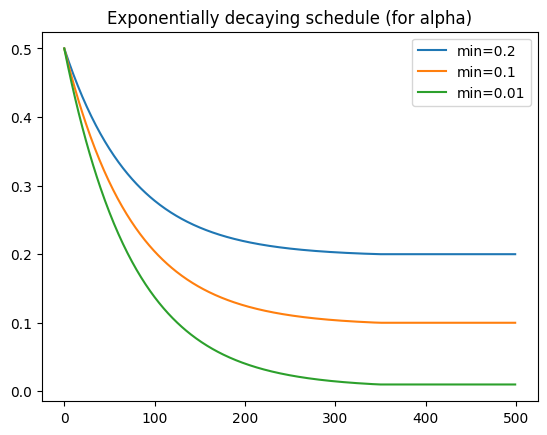

In [2]:
import matplotlib.pyplot as plt

plt.plot(decay_alpha(0.5, 0.2, 350, 500), label='min=0.2')
plt.plot(decay_alpha(0.5, 0.1, 350, 500), label='min=0.1')
plt.plot(decay_alpha(0.5, 0.01, 350, 500), label='min=0.01')
plt.title('Exponentially decaying schedule (for alpha)')
plt.legend()

plt.show()

We create also a function to calculate all the discount values for the full process:

In [3]:
def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

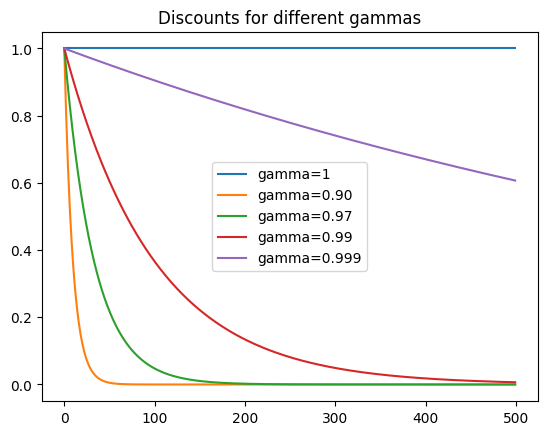

In [4]:
plt.plot(decay_discounts(1, 500), label='gamma=1')
plt.plot(decay_discounts(0.90, 500), label='gamma=0.90')
plt.plot(decay_discounts(0.97, 500), label='gamma=0.97')
plt.plot(decay_discounts(0.99, 500), label='gamma=0.99')
plt.plot(decay_discounts(0.999, 500), label='gamma=0.999')

plt.title('Discounts for different gammas')
plt.legend()

plt.show()

Then we write a function to run a policy over an environment and to extract the collection of experience tuples (called trajectory):

In [5]:
def generate_trajectory(pi, env, max_steps=200):
    
    # list of experiences (trajectory)
    trajectory = []
    
    done = False
    steps = 0
    
    # reset the environment to interact in a new episode
    state = env.reset()

    # looping through until the done flag is set to true
    while not done:     
        steps += 1;   

        # use the policy function to pick an action
        action = pi(state) 
            
        # step the environment using that action 
        next_state, reward, done, _ = env.step(action)
        
        # append the experience to the trajectory
        experience = (state, action, reward, next_state, done)
        trajectory.append(experience)
            
        # if we hit a terminal state break and return
        if done:
            break;
                
        # truncate long trajectories
        if steps > max_steps:
            break;
            
        # update the state
        state = next_state
            
    # return the trajectory
    return np.array(trajectory, object)

Now we can write the MC prediction function using the first-visit version:

In [6]:
def mc(pi, env, gamma=1.0, init_alpha=0.5, min_alpha=0.01, decay_episodes=350, n_episodes=500, max_steps=200):
    
    nS = env.observation_space
    
    # calculate all discounts at once. 
    discounts = decay_discounts(gamma, max_steps);
    
    # calculate all alphas at once
    alphas = decay_alpha(init_alpha, min_alpha, decay_episodes, n_episodes);
    
    # initialize the current estimate of the state-value function
    V = np.zeros(nS, dtype=float)
    
    # create a list to save copies of V for offline analysis
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    # loop for every episode 
    for e in range(n_episodes):
        
        # generate a trajectory
        trajectory = generate_trajectory(pi, env, max_steps)
        
        # initialize a visits check vector
        visited = np.zeros(nS, dtype=bool)
        
        # loop through all experiences in the trajectory
        for t, (state, _, reward, _, _) in enumerate(trajectory):
            
            # check if the state has already been visited
            if visited[state]: 
                continue
            visited[state] = True
            
            # calculate the number of steps from t to T
            n_steps = len(trajectory[t:])
            
            # calculate the return
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            
            # estimate the value function
            V[state] = V[state] + alphas[e] * (G - V[state])
        
            # keep track of the episode V
            V_track[e] = V
            
    return V.copy(), V_track

We ran the policy evaluation algorithms on the Random Walk (RW) environment.

In [7]:
import numpy as np
    
class RandomWalk:
    """
    State Index:   [ 0    1    2    3    4    5    6 ]
    State Label:   [ .    A    B    C    D    E    . ]
    Type:          [ T    .    .    S    .    .    T ]    
    """
    V_true =       [0.0, 1/6, 2/6, 3/6, 4/6, 5/6, 0.0]
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = 7
        self._state = np.random.choice([1,2,3,4,5])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: 
            raise ValueError('Episode has terminated');
        
        if action not in [0, 1]: 
            raise ValueError('Invalid action');
        
        self._state += np.random.choice([-1, 1])
        
        reward = 0
        
        if self._state < 1: 
            self._done = True
        
        if self._state > 5: 
            self._done = True; 
            reward = 1
        
        return self._state, reward, self._done, 0  # obs, rew, done

In [8]:
random_walk = RandomWalk()

We evaluate an "all-left" policy

In [9]:
def pi(state):
    return 1

We use the Monte Carlo prediction algorithm and show the estimates over episodes

In [10]:
V_mc, V_mc_track = mc(pi, random_walk, n_episodes=500);

In [11]:
print(V_mc)

[0.         0.15375541 0.32464285 0.50159415 0.67487762 0.83826672
 0.        ]


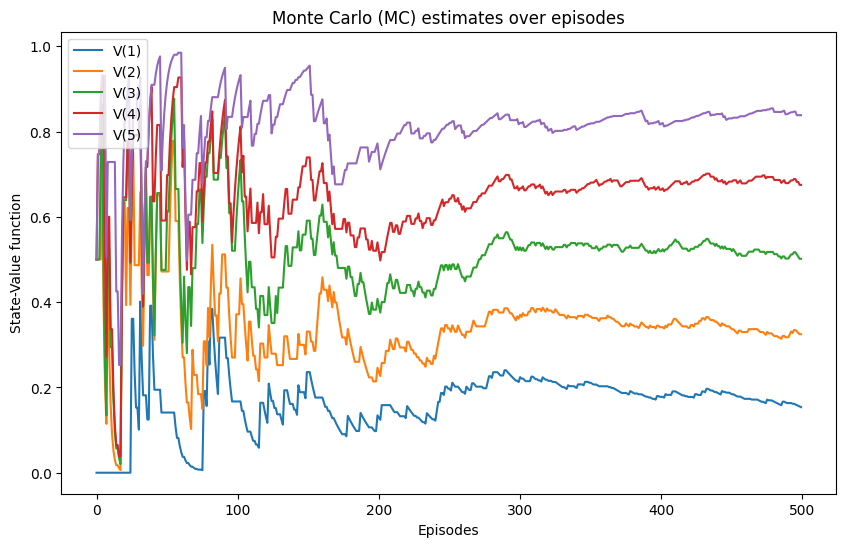

In [12]:
plt.figure(figsize=(10,6))

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)']
plt.plot(V_mc_track[:,1:6])
plt.title('Monte Carlo (MC) estimates over episodes')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()